# Make postISRCCD from DM PostISRCCD for Spectractor StandAlone


- work with Weakly_2023_44


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/09/20
- last update : 2023/12/20



write output file according hierarchy

         filter/DATE


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! echo $IMAGE_DESCRIPTION
! eups list -s lsst_distrib

Weekly 2023_44
   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits


In [4]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [5]:
import lsst.daf.butler as dafButler
from lsst.daf.butler import CollectionType

In [6]:
repo = "/sdf/group/rubin/repo/main" # repo/main
#repo="/sdf/group/rubin/repo/oga/"  # /repo/embargo
butler = dafButler.Butler(repo)
registry = butler.registry

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Registry

In [8]:
butler.registry.dimensions.getDatabaseElements()

NamedValueSet({DatabaseDimension(band), DatabaseDimension(detector), DatabaseDimension(physical_filter), DatabaseDimension(subfilter), DatabaseDimension(tract), DatabaseDimension(visit_system), DatabaseDimension(exposure), DatabaseDimension(patch), DatabaseDimension(visit), DatabaseDimensionCombination(visit_definition), DatabaseDimensionCombination(visit_detector_region), DatabaseDimensionCombination(visit_system_membership)})

In [9]:
print(butler.registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  seq_start: int
  seq_end: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  timespan: lsst.daf.butler.Timespan


In [10]:
print(butler.registry.dimensions["visit"].RecordClass.fields)

visit: 
  instrument: str
  id: int
  physical_filter: str
  name: str
  day_obs: int
  seq_num: int
  exposure_time: float
  target_name: str
  observation_reason: str
  science_program: str
  azimuth: float
  zenith_angle: float
  region: lsst.sphgeom.Region
  timespan: lsst.daf.butler.Timespan


In [11]:
print(butler.registry.dimensions["physical_filter"].RecordClass.fields)

physical_filter: 
  instrument: str
  name: str
  band: str


In [12]:
print(butler.registry.dimensions["tract"].RecordClass.fields)

tract: 
  skymap: str
  id: int
  region: lsst.sphgeom.Region


# Configuration

In [13]:
FLAG_PLOT=True

In [14]:
#DATE = 20230912
#FILTER="cyl_lens~holo4_001"
#FILTER="cyl_lens~holo4_003"

#my_collection = "u/dagoret/spectro/collimatorholo4003noflat/runs_20230912"
#FILTER="collimator~holo4_003"
#my_collection = "u/dagoret/spectro/emptyholo4003noflat/runs_20230912"
#FILTER="empty~holo4_003"
#my_collection = "u/dagoret/spectro/emptyholo4001noflat/runs_20230912"
#FILTER="empty~holo4_001"


#DATE = 20230913
#my_collection = "u/dagoret/spectro/collimatorholo4003noflat/runs_20230913"
#FILTER="collimator~holo4_003"
#my_collection = "u/dagoret/spectro/emptyholo4003noflat/runs_20230913"
#FILTER="empty~holo4_003"
#my_collection = "u/dagoret/spectro/emptyholo4001noflat/runs_20230913"
#FILTER="empt~holo4_001"



#DATE = 20230914
#my_collection = "u/dagoret/spectro/collimatorholo4003noflat/runs_20230914"
#FILTER="collimator~holo4_003"
#my_collection = "u/dagoret/spectro/emptyholo4003noflat/runs_20230914"
#FILTER="empty~holo4_003"
#my_collection = "u/dagoret/spectro/emptyholo4001noflat/runs_20230914"
#FILTER="empty~holo4_001"


#DATE = 20230117
#my_collection = "u/dagoret/BPS_manyspectro_v100"
#FILTER="empty~holo4_003"



#DATE = 20230118
#my_collection = "u/dagoret/BPS_manyspectro_v102"
#FILTER="empty~holo4_003"



#DATE = 20211006
#my_collection = "u/dagoret/spectro/w_2023_44_spec3.0.3/holo_SDSS_g_oct2021"
#FILTER="SDSSg~holo4_003"

DATE = 20211103
my_collection = "u/dagoret/spectro/w_2023_44_spec3.0.3/holo_SDSS_g_nov2021"
FILTER="SDSSg~holo4_003"



In [15]:
# output path of type top/date/filter
#----------------------------------------

top_path_out="dm_postisrccd_img"
path_out=f"{top_path_out}/{FILTER}"

In [16]:
if not os.path.exists(path_out):
    os.makedirs(path_out)

In [17]:
path_out=f"{path_out}/{DATE}"

if not os.path.exists(path_out):
    os.makedirs(path_out)

# read list of exposures

From the butler and the given user collection

In [18]:
datasetRefs = registry.queryDatasets(datasetType='postISRCCD', collections=my_collection, where= "instrument='LATISS'")

In [19]:
all_dataId = []
all_postisrccd  = []
all_exposures = []
for i, ref in enumerate(datasetRefs):
   
    print(f"========({i})================datasetType = postISRCCD ============================================")
    print("fullId..................:",ref.dataId.full)
    print("exposure................:",ref.dataId["exposure"])
    print("band....................:",ref.dataId["band"])
    print("physical filter.........:",ref.dataId["physical_filter"])
    print("run.....................:",ref.run)
    the_exposure = ref.dataId["exposure"]
    the_day_obs = ref.dataId["exposure"]//100_000
    the_seq_num = ref.dataId["exposure"]- the_day_obs*100_000    
    the_dataId = {'day_obs': the_day_obs,'seq_num':the_seq_num,'detector':0}
    print(the_dataId)
    #spec       = butler.get('spectraction',the_dataId)
    postisrccd = butler.get('postISRCCD', exposure=the_exposure, detector=0, collections=my_collection, instrument='LATISS')
    all_dataId.append(the_dataId) 
    all_exposures.append(the_exposure)
    all_postisrccd.append(postisrccd)
all_exposures = np.array(all_exposures)

========(0)================datasetType = postISRCCD ============================================
fullId..................: {band: 'g', instrument: 'LATISS', detector: 0, physical_filter: 'SDSSg~holo4_003', exposure: 2021110300533}
exposure................: 2021110300533
band....................: g
physical filter.........: SDSSg~holo4_003
run.....................: u/dagoret/spectro/w_2023_44_spec3.0.3/holo_SDSS_g_nov2021/20231220T202528Z
{'day_obs': 20211103, 'seq_num': 533, 'detector': 0}
========(1)================datasetType = postISRCCD ============================================
fullId..................: {band: 'g', instrument: 'LATISS', detector: 0, physical_filter: 'SDSSg~holo4_003', exposure: 2021110300539}
exposure................: 2021110300539
band....................: g
physical filter.........: SDSSg~holo4_003
run.....................: u/dagoret/spectro/w_2023_44_spec3.0.3/holo_SDSS_g_nov2021/20231220T202528Z
{'day_obs': 20211103, 'seq_num': 539, 'detector': 0}


In [20]:
N = len(all_postisrccd)

In [21]:
all_exposures_sortedindexes = np.argsort(all_exposures)

In [22]:
all_exposures[all_exposures_sortedindexes]

array([2021110300533, 2021110300539])

In [23]:
for idx in range(N):
    idx_sorted = all_exposures_sortedindexes[idx]
    dm_postisrccd = all_postisrccd[idx_sorted]
    dm_postisrccd_md = dict(dm_postisrccd.getMetadata())
    print(f"==================={all_exposures[idx_sorted]}=======================")
    print('LSST CALIB DATE BIAS :',dm_postisrccd_md['LSST CALIB DATE BIAS'])
    print('LSST CALIB UUID BIAS :',dm_postisrccd_md['LSST CALIB UUID BIAS']) 
    print('LSST CALIB RUN BIAS  :',dm_postisrccd_md['LSST CALIB RUN BIAS'])
    print("-------")
    print('LSST CALIB DATE DEFECTS :',dm_postisrccd_md['LSST CALIB DATE DEFECTS'])
    print('LSST CALIB UUID DEFECTS :',dm_postisrccd_md['LSST CALIB UUID DEFECTS']) 
    print('LSST CALIB RUN DEFECTS  :',dm_postisrccd_md['LSST CALIB RUN DEFECTS'])

===================2021110300533=======================
LSST CALIB DATE BIAS : 2021-07-02 16:54:53 CDT
LSST CALIB UUID BIAS : ece87a4e-0180-4613-aa6d-119a84881ccc
LSST CALIB RUN BIAS  : u/czw/DM-28920/biasGen.20210702a/20210702T215049
-------
LSST CALIB DATE DEFECTS : 2022-06-08 17:35:34
LSST CALIB UUID DEFECTS : 5bf77ea9-7838-4502-964a-6b3ee3c6127a
LSST CALIB RUN DEFECTS  : u/czw/calibX.20220608
===================2021110300539=======================
LSST CALIB DATE BIAS : 2021-07-02 16:54:53 CDT
LSST CALIB UUID BIAS : ece87a4e-0180-4613-aa6d-119a84881ccc
LSST CALIB RUN BIAS  : u/czw/DM-28920/biasGen.20210702a/20210702T215049
-------
LSST CALIB DATE DEFECTS : 2022-06-08 17:35:34
LSST CALIB UUID DEFECTS : 5bf77ea9-7838-4502-964a-6b3ee3c6127a
LSST CALIB RUN DEFECTS  : u/czw/calibX.20220608


## Select flags options

In [24]:
FLAG_ROTATE_IMG = True
FLAG_TRANSFORM = True

## Transformations
astropy scale transformations

In [25]:
transform = AsinhStretch() + PercentileInterval(99.)
#transform = PercentileInterval(98.)



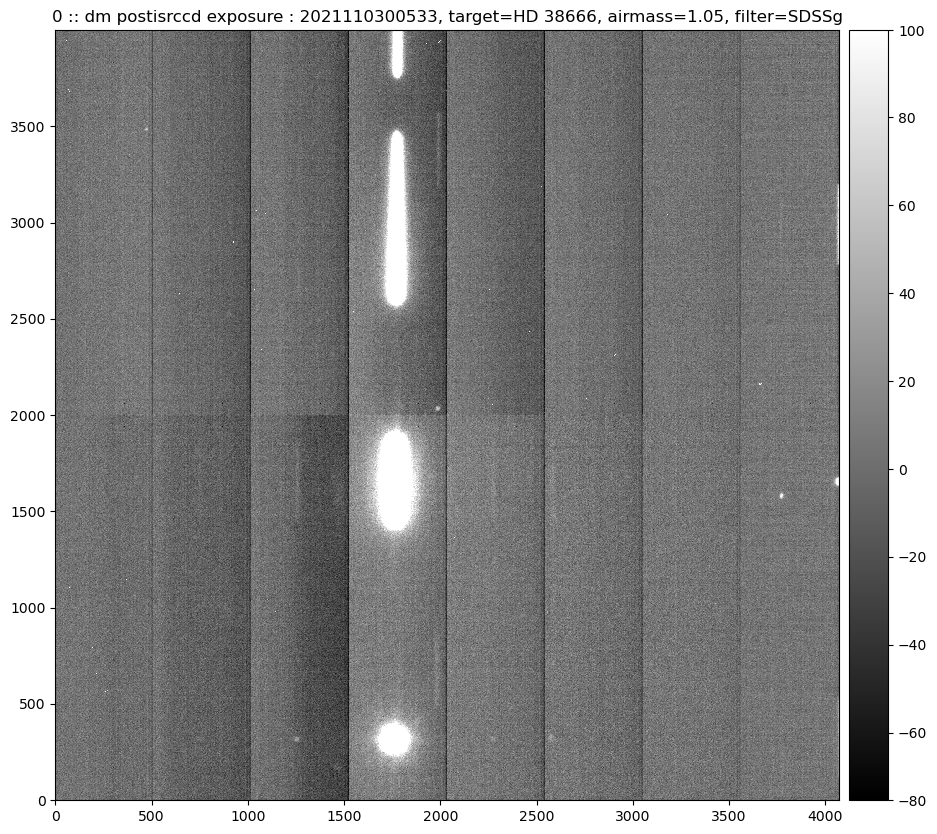

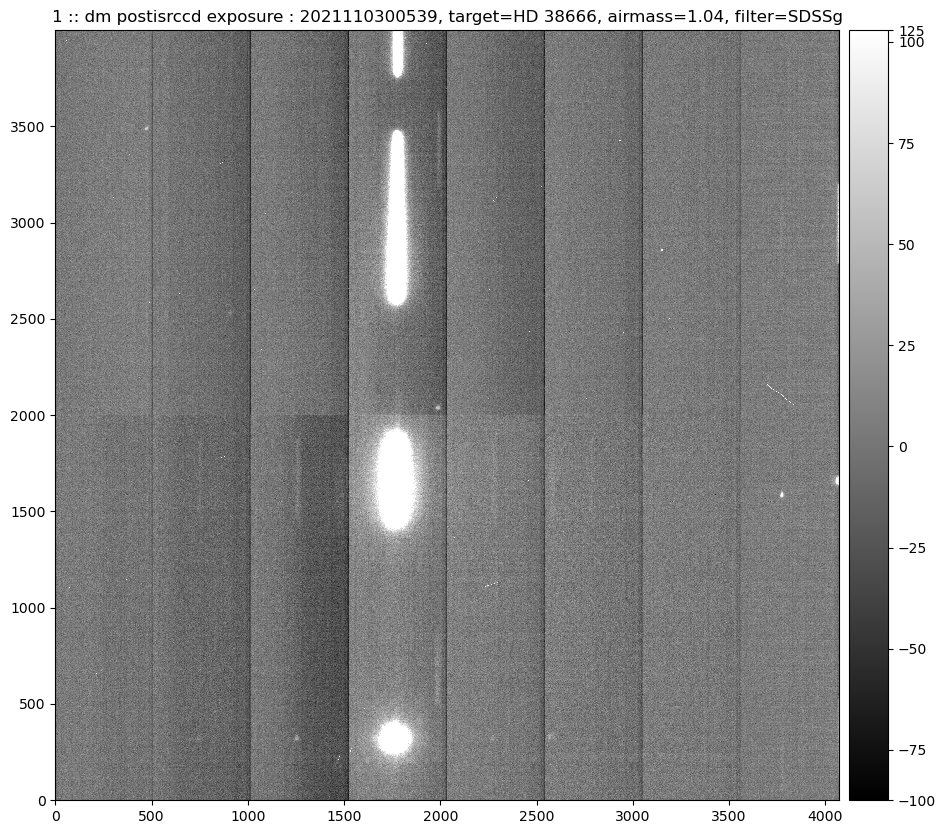

In [26]:
%matplotlib inline
if FLAG_PLOT:
    for idx in range(N):
        idx_sorted = all_exposures_sortedindexes[idx]
        dm_postisrccd = all_postisrccd[idx_sorted]
        dm_postisrccd_md = dict(dm_postisrccd.getMetadata())
        exposure_selected =all_exposures[idx_sorted]
        raw_img= butler.get('raw', dataId={'exposure': exposure_selected, 'instrument': 'LATISS', 'detector': 0}, collections = ['LATISS/calib','LATISS/raw/all',] )

        meta = raw_img.getMetadata()
        md = meta.toDict()


        the_object = md['OBJECT']
        
        if the_object == "MU-COL":
            md['OBJECT']="HD38666"
            the_object = md['OBJECT']
            
        if the_object == "ETA1-DOR":
            md['OBJECT']="HD42525"
            the_object = md['OBJECT']
            
            
        the_am= md['AMSTART']
        the_filter=md['FILTER']
    
        
    
        rotated_array = dm_postisrccd.image.array[::-1,::-1] #rotate the array 180 degrees
        #np.flip(np.flip(a, 1), 0)

    
        fig = plt.figure(figsize=(12,10))
        afw_display = afwDisplay.Display(frame=fig)
        afw_display.scale('linear', 'zscale',None)
        the_title = f"{idx} :: dm postisrccd exposure : {exposure_selected}, target={the_object}, airmass={the_am:.2f}, filter={the_filter}"
        afw_display.mtv(dm_postisrccd.image,title=the_title)

In [27]:
#dm_postisrccd_md 

In [28]:
#md

# Save in files
Note only header of raw image is saved because OBJECT name is only in raw image header.
It is possible to do a clever mixture of both headers later

In [29]:
for idx in range(N):
    idx_sorted = all_exposures_sortedindexes[idx]
    dm_postisrccd = all_postisrccd[idx_sorted]
    dm_postisrccd_md = dict(dm_postisrccd.getMetadata())
    exposure_selected =all_exposures[idx_sorted]
    raw_img= butler.get('raw', dataId={'exposure': exposure_selected, 'instrument': 'LATISS', 'detector': 0}, collections = ['LATISS/calib','LATISS/raw/all',] )

    meta = raw_img.getMetadata()
    md = meta.toDict()
      
    
    print(f"save exposure selected = {exposure_selected}")

    # we will save the postisrccd image
    arr=dm_postisrccd.image.array
    # 180 degree rotation
    rotated_array = arr[::-1,::-1] #rotate the array 180 degrees
    
    
    meta = raw_img.getMetadata()
    md = meta.toDict()

    the_object = md['OBJECT']
    the_am= md['AMSTART']
    the_filter=md['FILTER']
    
    if the_object == "MU-COL":
        md['OBJECT']="HD38666"
        the_object = md['OBJECT']

    filename_out = f"exposure_{exposure_selected}_dmpostisrccd.fits"
    fullfilename_out=os.path.join(path_out,filename_out)
    
    print(f">>>>  output filename {filename_out} object {the_object}")
    
    hdr = fits.Header()
    
    for key,value in md.items():
        if key == 'OBJECT':
            print(key,value)
        hdr[str(key)]=value
        
    # need this    
    hdr["AMEND"] = hdr["AMSTART"]
    
    # be aware weather data may be missing
    if hdr["AIRTEMP"] == None:
        hdr["AIRTEMP"] = 10.0
        print("AIRTEMP key missing")

    if hdr["PRESSURE"] == None:
        hdr["PRESSURE"] = 744.
        print("PRESSURE key missing")

    if hdr["HUMIDITY"] == None:
        hdr["HUMIDITY"] = 50.
        print("HUMIDITY key missing")

    if hdr["WINDSPD"] == None:
        hdr["WINDSPD"] = 5.
        print("WINDSPD key missing")

    if hdr["WINDDIR"] == None:
        hdr["WINDDIR"] = 0.
        print("WINDDIR key missing")

    if hdr["SEEING"] == None:
        hdr["SEEING"] = 1.15
        print("SEEING key missing")
       
    
    # Be carefull for Spectractor Standalone, 2 hdu units are necessary
    
    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(rotated_array)
    hdu_list = fits.HDUList([primary_hdu, image_hdu])
    hdu_list.writeto(fullfilename_out,overwrite=True)
    
    
    #if index>=0:
    #    break
    


save exposure selected = 2021110300533
>>>>  output filename exposure_2021110300533_dmpostisrccd.fits object HD 38666
OBJECT HD 38666


save exposure selected = 2021110300539
>>>>  output filename exposure_2021110300539_dmpostisrccd.fits object HD 38666
OBJECT HD 38666


In [30]:
print("finished")

finished
